## Price Per Square Foot Prediction
In this notebook I predict the price per square foot of a house in Nashville, using an XGBoost. 
Metrics used are root mean squared error, median absolute error, mean absolute error and coefficient of determination.

Since almost all numerical features of the dataset were heavily right-skewed, I have log-transformed every numerical feature except for the target variable (PPS). The 'Year Built' feature was given a log(2020-x)^1.5 transform to correct left-skew.

I also ran a LightGBMRegressor which got almost identical results, but ran much faster.

### Observations

Quarter and Year are pretty essential variables but I wonder if there's a better way to incorporate time.


### Next step: incorporate data from historical sales.

### Consider adding average fixtures per house in the neighborhood?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')

In [2]:
import prepper
nash = prepper.prep('joined_20190912141026.csv')

In [3]:
#Clearing out a few outliers.
#Removing massive parcels of land isn't so much about them being outliers; this model is for urban development.
print(nash['Fixtures'].quantile([.97,.985,.995]))
nash=nash[nash.Fixtures <=23]

print(nash['Land Area Acres'].quantile([.97,.985,.995]))
nash=nash[nash['Land Area Acres'] <=3]

#Giving PPS more leeway because it's our target variable (and it varies more)
print(nash['PPS'].quantile([.97,.985,.997]))
nash=nash[nash.PPS <= 700]

0.970    18.0
0.985    20.0
0.995    24.0
Name: Fixtures, dtype: float64
0.970    1.05
0.985    1.39
0.995    2.47
Name: Land Area Acres, dtype: float64
0.970    358.969517
0.985    434.255121
0.997    591.063686
Name: PPS, dtype: float64


## First, checking what the absolute smallest and largest PPS observations are.

In [4]:
nash.nsmallest(5, 'PPS')[['Location', 'Zone', 'Sale Price', 'PPS', 'Square Footage Improved', 'Building Type Custom', 'Building Condition']]

,Location,Zone,Sale Price,PPS,Square Footage Improved,Building Type Custom,Building Condition
427506,690 CANDLESTICK DR,1.0,49.0,0.027313,1794.0,SINGLE FAM,Average
442485,5441 CAMELOT RD,2.0,10000.0,2.211411,4522.0,SINGLE FAM,Average
490334,1013 SUMMERCREST CT,8.0,10000.0,4.108463,2434.0,SINGLE FAM,Average
390376,64 VALERIA ST,1.0,5000.0,4.340278,1152.0,SINGLE FAM,Average
368865,31 N HILL ST,1.0,10001.0,4.857212,2059.0,SINGLE FAM,Average


In [5]:
nash.nlargest(5,'NeighborhoodPPS')[['Neighborhood','NeighborhoodPPS']]

,Neighborhood,NeighborhoodPPS
530621,6264.0,752.879821
530592,6264.0,752.879821
530649,6264.0,752.879821
530607,6264.0,752.879821
530647,6264.0,752.879821


## Next, checking the distribution of several numerical features.
I'll end up log-transforming all of these.
'Fixtures' doesn't appear skewed, but the model performs slightly better when it's transformed.

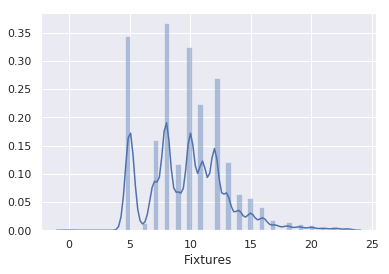

In [6]:
sns.distplot(nash['Fixtures'].dropna())

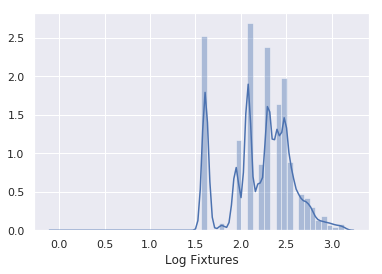

In [7]:
#Not very different, but the model performs slightly better when it's transformed
sns.distplot(nash['Log Fixtures'].dropna())

In [8]:
nash.nlargest(10, 'Land Area Acres')

,Assessment Improvement,Assessment Land,Assessment Total,Assessment Year,Baths,Baths2,Beds,Beds2,Building Condition,Building Condition2,...,Quarter,Year,Log Assessment,Log Fixtures,Log SqFt,Log PPS,Log Land,Log NbhdPPS,Log NbhdRatio,Log Built
13282,"$44,250","$20,250","$64,500",2019.0,3.0,NaN,3.0,NaN,Fair,NaN,...,2,2015,9.915910,2.397895,7.888335,4.540882,1.098612,4.772120,-2.603969,6.861616
458775,"$41,100","$31,250","$72,350",2019.0,2.0,NaN,3.0,NaN,Average,NaN,...,3,2015,10.349775,2.079442,7.604396,5.130915,1.098612,4.934089,-2.912313,7.226057
458772,"$45,450","$31,250","$76,700",2019.0,2.0,NaN,4.0,NaN,Average,NaN,...,3,2016,10.349775,2.079442,7.893572,4.567143,1.098612,4.934089,-2.912313,7.226057
355685,"$91,950","$20,000","$111,950",2019.0,3.0,NaN,4.0,NaN,Average,NaN,...,3,2016,9.903488,2.397895,8.193400,4.482676,1.098612,4.768629,-2.816275,7.966975
458773,"$63,150","$31,250","$94,400",2019.0,4.0,NaN,4.0,NaN,Average,NaN,...,4,2016,10.349775,2.484907,7.813996,5.157545,1.098612,4.934089,-2.912313,7.156288
411432,"$39,775","$18,000","$57,775",2019.0,1.0,NaN,3.0,NaN,Average,NaN,...,4,2016,9.798127,1.945910,7.712444,4.675950,1.098612,4.820341,-2.887247,7.491470
396253,"$95,200","$29,000","$124,200",2019.0,3.0,NaN,5.0,NaN,Average,NaN,...,4,2016,10.275051,2.397895,8.311890,4.800423,1.098612,5.075999,-2.605345,7.491470
334000,"$78,000","$131,720","$209,720",2019.0,3.0,NaN,3.0,NaN,Average,NaN,...,1,2017,11.788434,2.564949,8.050384,4.512488,1.098612,4.512488,-1.381386,7.677665
414715,"$139,550","$29,000","$168,550",2019.0,4.0,NaN,3.0,NaN,Average,NaN,...,2,2017,10.275051,2.833213,8.429891,5.010926,1.098612,5.075999,-2.605345,5.312253
22761,"$21,875","$12,000","$33,875",2019.0,1.0,NaN,2.0,NaN,Average,NaN,...,2,2017,9.392662,1.609438,7.259116,4.754585,1.098612,4.646261,-2.130727,8.334916


## Now to the Machine Learning:

First I'll run a dummy regressor, which just guesses the median. Then I'll attempt a few different models with increasing accuracy.

In [9]:
#Important metric to keep in mind when judging your model's performance.
np.std(nash.PPS)

78.4120934803892

In [10]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import median_absolute_error as MAE
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error as MSLE
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

ML = nash[['Sale Date', 'Neighborhood','Log Built','Log NbhdRatio','Building Condition',
           'Log SqFt','Log Fixtures','Building Type Custom','Building Grade',
           'Exterior Wall','Year','Log NbhdPPS', 'PPS', 'Quarter', 'Log Assessment', 
           'Year Built', 'Zone']].dropna()
ML.sort_values(by = 'Sale Date', ascending=True, inplace=True)

#dtreeviz doesn't work with features whose names have spaces.
ML.columns = ['Sale-Date', 'Neighborhood', 'Log-Built','Log-NbhdRatio', 'Building-Condition', 
              'Log-SqFt', 'Log-Fixtures', 'Building-Type-Custom', 'Building-Grade', 
              'Exterior-Wall', 'Year', 'Log-NbhdPPS', 'PPS', 'Quarter', 'Log-Assessment', 
              'Year-Built', 'Zone']

print(nash.shape)
print(ML.shape)

X= pd.get_dummies(ML[['Log-Built','Log-NbhdPPS','Log-SqFt','Log-Fixtures', 
                      'Quarter', 'Building-Grade', 'Building-Type-Custom', 
                      'Neighborhood', 'Year']])
y=ML['PPS']

(53727, 83)
(53651, 17)


In [11]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

scoring = ['r2', 'neg_mean_absolute_error', 'neg_median_absolute_error', 
           'neg_mean_squared_error', 'neg_mean_squared_log_error']


In [12]:
from sklearn.dummy import DummyRegressor as DR
model = DR(strategy='median')
model.fit(X_train, y_train)
y_pred= model.predict(X_test)
scoring = ['r2', 'neg_mean_absolute_error', 'neg_median_absolute_error', 
           'neg_mean_squared_error', 'neg_mean_squared_log_error']
scores = cross_validate(model, X_train, y_train, cv=tscv, 
                        scoring=scoring, return_train_score=False)
for score in scores:
    print(f'Time Series CV score of {score}: {scores[score][4]}')

Time Series CV score of fit_time: 0.05240631103515625
Time Series CV score of score_time: 0.00209808349609375
Time Series CV score of test_r2: -0.3817911654551378
Time Series CV score of test_neg_mean_absolute_error: -63.848761008744646
Time Series CV score of test_neg_median_absolute_error: -42.35191330651084
Time Series CV score of test_neg_mean_squared_error: -8785.66282550144
Time Series CV score of test_neg_mean_squared_log_error: -0.213632759636101


In [13]:
from sklearn.tree import DecisionTreeRegressor as DTR
model = DTR()
model.fit(X_train, y_train)
y_pred= model.predict(X_test)
scoring = ['r2', 'neg_mean_absolute_error', 'neg_median_absolute_error', 
           'neg_mean_squared_error', 'neg_mean_squared_log_error']
scores = cross_validate(model, X_train, y_train, cv=tscv, 
                        scoring=scoring, return_train_score=False)
for score in scores:
    print(f'Time Series CV score of {score}: {scores[score][4]}')

Time Series CV score of fit_time: 1.3117213249206543
Time Series CV score of score_time: 0.08158469200134277
Time Series CV score of test_r2: 0.647011270713491
Time Series CV score of test_neg_mean_absolute_error: -30.970689344418805
Time Series CV score of test_neg_median_absolute_error: -19.476744186046517
Time Series CV score of test_neg_mean_squared_error: -2244.3622699613798
Time Series CV score of test_neg_mean_squared_log_error: -0.10647034294468107


In [14]:
from sklearn.ensemble import RandomForestRegressor as RFR
model = RFR(random_state=42)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
scoring = ['r2', 'neg_mean_absolute_error', 'neg_median_absolute_error', 
           'neg_mean_squared_error', 'neg_mean_squared_log_error']
scores = cross_validate(model, X_train, y_train, cv=tscv, 
                        scoring=scoring, return_train_score=False)
for score in scores:
    print(f'Time Series CV score of {score}: {scores[score][4]}')

/home/drew/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Time Series CV score of fit_time: 7.551523685455322
Time Series CV score of score_time: 0.19121193885803223
Time Series CV score of test_r2: 0.7643059076005914
Time Series CV score of test_neg_mean_absolute_error: -25.718621377336543
Time Series CV score of test_neg_median_absolute_error: -16.851377947639037
Time Series CV score of test_neg_mean_squared_error: -1498.5830547713226
Time Series CV score of test_neg_mean_squared_log_error: -0.053657392655272446


### Now testing Microsoft's LightGBM

LightGBM runs much faster (which gives me more time for tuning) than XGBoost and includes some built-in graphing abilities. Performance is generally about the same, but sometimes better than XGBoost, depending on the dataset.

Important: LightGBM's .train() module must call the proprietary Dataset format to train on. The .train() module must be called to save the regressor model. So I've trained it on the first 4 parts of the timeseries and tested it on the 5th (most recent).



/home/drew/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's l1: 18.3454	valid_1's l1: 26.0732
[200]	training's l1: 17.6835	valid_1's l1: 25.6962
[300]	training's l1: 17.2001	valid_1's l1: 25.5078
[400]	training's l1: 16.8897	valid_1's l1: 25.4507
[500]	training's l1: 16.5923	valid_1's l1: 25.4372
[600]	training's l1: 16.3289	valid_1's l1: 25.3311
[700]	training's l1: 16.1096	valid_1's l1: 25.245
[800]	training's l1: 15.8895	valid_1's l1: 25.2026
[900]	training's l1: 15.7041	valid_1's l1: 25.1328
[1000]	training's l1: 15.5704	valid_1's l1: 25.1007
RMSE: 41.499939498722995
Median Absolute Error: 14.080961176976473
Mean Absolute Error: 25.100730976361145
Coefficient of Determination: 0.7388792392633357
Root Mean Squared Logarithmic Error: 0.26550327532446566


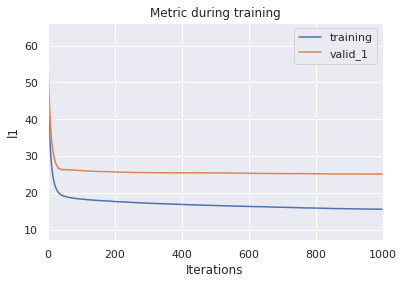

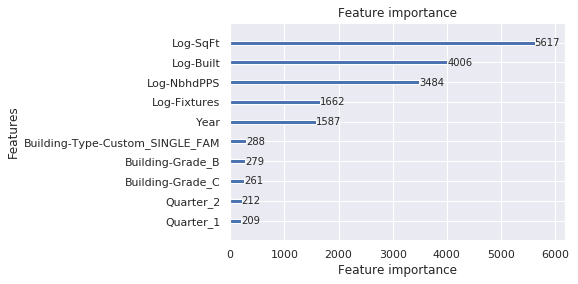

In [15]:
import lightgbm as lgb

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_test,y_test)
#Best parameters from GridSearchCV
evals_result={}
params = {'objective':'regression_l1', 'max_depth': 7,'reg_alpha':2, 'metric':'l1', 
          'min_child_weight': 40, 'n_estimators': 1000, 'num_leaves': 250}
gbm = lgb.train(params=params,
                train_set= dtrain,
                valid_sets=[dtrain, dvalid],
                evals_result=evals_result,
                verbose_eval=100)
y_predgbm=gbm.predict(X_test)
print('RMSE: {}'.format(MSE(y_test,y_predgbm)**0.5))
print('Median Absolute Error: {}'.format(MAE(y_test,y_predgbm)))
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_predgbm)))
print('Coefficient of Determination: {}'.format(r2_score(y_test, y_predgbm)))
print('Root Mean Squared Logarithmic Error: {}'.format(MSLE(np.abs(y_predgbm),np.abs(y_test))**0.5))
lgb.plot_metric(booster=evals_result)
lgb.plot_importance(gbm, max_num_features=10)

gbm.save_model('pps-model.txt')

In [16]:
# from sklearn.model_selection import GridSearchCV
# estimator = lgb.LGBMRegressor()
# evals_result={}
# param_grid = {
#     'learning_rate': [0.18,0.21],
#     'n_estimators': [500],
#     'min_child_weight':[30,50],
#     'max_depth': [5],
#     'num_leaves': [350]
#     }
# params={}
# gbmcv = GridSearchCV(estimator, param_grid, cv=5, scoring ='neg_mean_squared_error')
# gbmcv.fit(X_train, y_train)
# y_predlgb= gbmcv.predict(X_test)
# print('Best parameters found by grid search are:', gbmcv.best_params_)
# print(gbmcv.best_score_)
# print(MSE(y_test,y_predlgb)**0.5)
# print(MAE(y_test,y_predlgb))
# print(mean_absolute_error(y_test, y_predlgb))
# print(r2_score(y_test, y_predlgb))

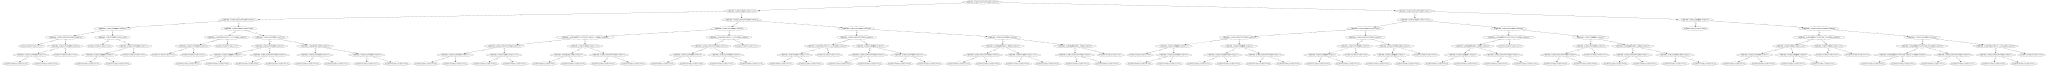

<Figure size 720x720 with 0 Axes>

In [17]:
plt.figure(figsize=(10,10))
lgb.create_tree_digraph(booster=gbm, precision=3)

#### This is an LGBMRegressor instance using the TimeSeriesSplit method, for comparison to the lgb.train instance above.
#### It exhibits a larger error than the .train() module, with any set of parameters.

In [18]:

from lightgbm import LGBMRegressor
params = {'objective':'regression_l1', 'learning_rate': 0.18, 'max_depth': 5, 'min_child_weight': 30, 'n_estimators': 1000, 'num_leaves': 300}
final = LGBMRegressor(objective='regression_l1')
final.fit(X_train, y_train)
y_predfinal=final.predict(X_test)
scoring = ['r2', 'neg_mean_absolute_error', 'neg_median_absolute_error', 
           'neg_mean_squared_error', 'neg_mean_squared_log_error']
scores = cross_validate(final, X_train, y_train, cv=tscv, 
                        scoring=scoring, return_train_score=False)
for score in scores:
    print(f'Time Series CV score of {score}: {scores[score][4]}')

Time Series CV score of fit_time: 1.232581615447998
Time Series CV score of score_time: 1.4909353256225586
Time Series CV score of test_r2: 0.7275390969213312
Time Series CV score of test_neg_mean_absolute_error: -27.704022929042154
Time Series CV score of test_neg_median_absolute_error: -18.037825797488466
Time Series CV score of test_neg_mean_squared_error: -1732.352679207029
Time Series CV score of test_neg_mean_squared_log_error: -0.057794852684566585


## Examining residual errors

In [19]:
copiedlgb= X_test.copy()
copiedlgb['Actual']= y_test
copiedlgb['Predicted']= y_predgbm
copiedlgb['Residual'] = np.absolute(copiedlgb['Actual'] - copiedlgb['Predicted'])
copiedlgb.nlargest(15, 'Residual')

,Log-Built,Log-NbhdPPS,Log-SqFt,Log-Fixtures,Year,Quarter_1,Quarter_2,Quarter_3,Quarter_4,Building-Grade_A,...,Neighborhood_9335.0,Neighborhood_9336.0,Neighborhood_9526.0,Neighborhood_9527.0,Neighborhood_9528.0,Neighborhood_9529.0,Neighborhood_9530.0,Actual,Predicted,Residual
500882,3.917104,6.227716,6.765039,1.609438,2018,0,0,0,1,0,...,0,0,0,0,0,0,0,44.405998,494.637860,450.231862
45773,8.481352,5.047013,6.895683,1.609438,2019,0,1,0,0,0,...,0,0,0,0,0,0,0,506.072874,151.620618,354.452256
387034,0.000000,5.552479,8.133881,2.639057,2019,1,0,0,0,0,...,0,0,0,0,0,0,0,434.332453,97.654581,336.677872
368264,7.616730,5.587068,7.057037,1.609438,2018,0,0,0,1,0,...,0,0,0,0,0,0,0,645.994832,318.185659,327.809173
523453,0.577083,5.312365,7.375882,2.397895,2018,0,0,0,1,0,...,0,0,0,0,0,0,0,525.986224,215.300793,310.685431
45775,8.481352,5.047013,7.090077,1.609438,2019,0,1,0,0,0,...,0,0,0,0,0,0,0,416.666667,124.498380,292.168287
400730,0.000000,5.720622,8.249314,2.995732,2019,0,1,0,0,0,...,0,0,0,0,0,0,0,469.672157,191.074147,278.598010
401051,6.272602,5.658189,8.589328,2.995732,2018,0,0,0,1,0,...,0,0,0,0,0,0,0,558.243394,281.572429,276.670965
479301,10.738993,6.261019,7.824046,2.484907,2018,0,0,0,1,0,...,0,0,0,0,0,0,0,292.000000,560.317082,268.317082
301385,9.717889,5.217480,7.321189,1.609438,2019,1,0,0,0,0,...,0,0,0,0,0,0,0,429.894180,167.520676,262.373504


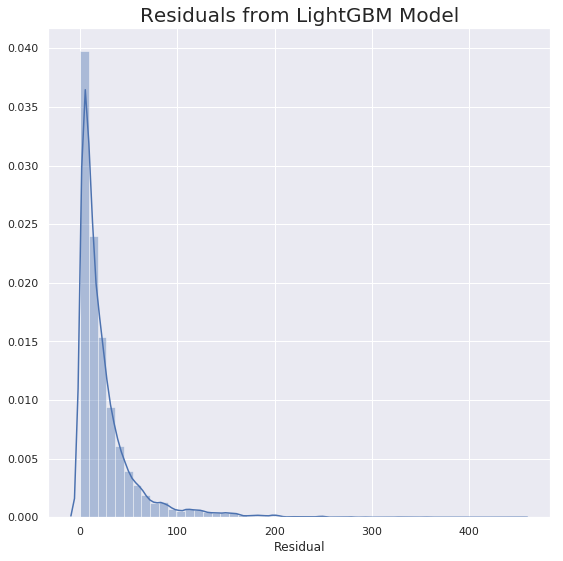

In [20]:
plt.figure(figsize=(9,9))
plt.title('Residuals from LightGBM Model',fontsize=20)
sns.distplot(copiedlgb.Residual.dropna())

## Interpretting the Model:
It looks like the biggest residuals are for houses where the actual PPS was very different from the average PPS in the neighborhood.


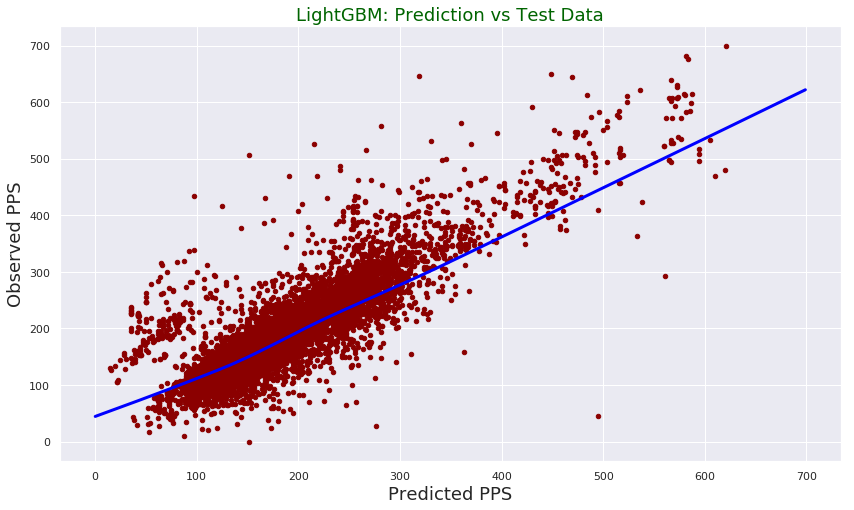

In [21]:
import statsmodels as sm
lowess = sm.nonparametric.smoothers_lowess.lowess
z = lowess(y_predgbm, y_test)
test = pd.DataFrame({"prediction": copiedlgb['Predicted'], "observed": copiedlgb['Actual']})
test.plot(figsize = [14,8],
          x ="prediction", y = "observed", kind = "scatter", color = 'darkred')
plt.title("LightGBM: Prediction vs Test Data", fontsize = 18, color = "darkgreen")
plt.xlabel("Predicted PPS", fontsize = 18) 
plt.ylabel("Observed PPS", fontsize = 18)
plt.plot(z[:,0], z[:,1], color = "blue", lw= 3)
plt.show()

### Visualizing in 3 dimensions:

The observations with the highest residual error are up (high Neighborhood PPS), to the left (low PPS), and back (high residual error)

Conversely, some observations with a high residual (located at the back wall) are near the bottom of the back (low NeighborhoodPPS) but to the right (high observation PPS)

Text(0.5, 0, 'Z: Neighborhood PPS')

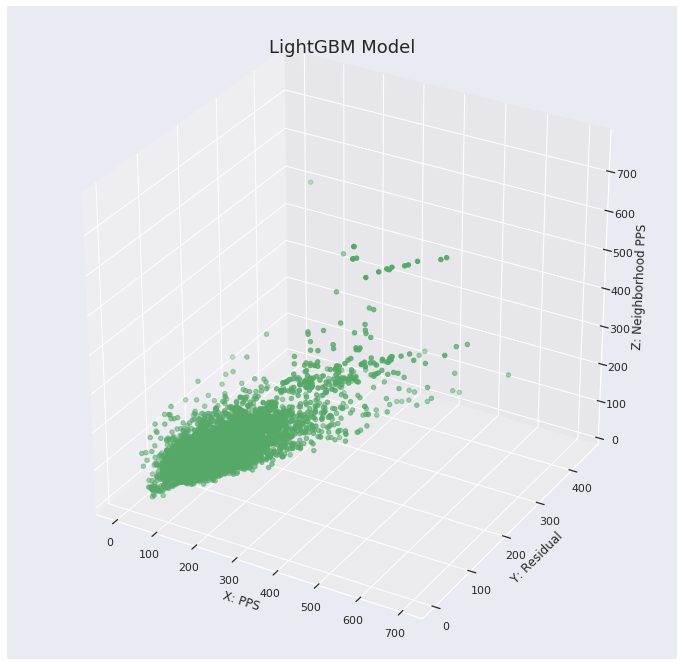

In [22]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

x =copiedlgb['Actual']
y =copiedlgb['Residual']
z =copiedlgb['Log-NbhdPPS'].map(lambda x: np.exp(x))
plt.title('LightGBM Model', fontsize=18)
ax.scatter(x, y, z, c='g', marker='o')
ax.set_xlabel('X: PPS')
ax.set_ylabel('Y: Residual')
ax.set_zlabel('Z: Neighborhood PPS')


#To clarify: these 

Text(0.5, 1.0, 'LightGBM Model')

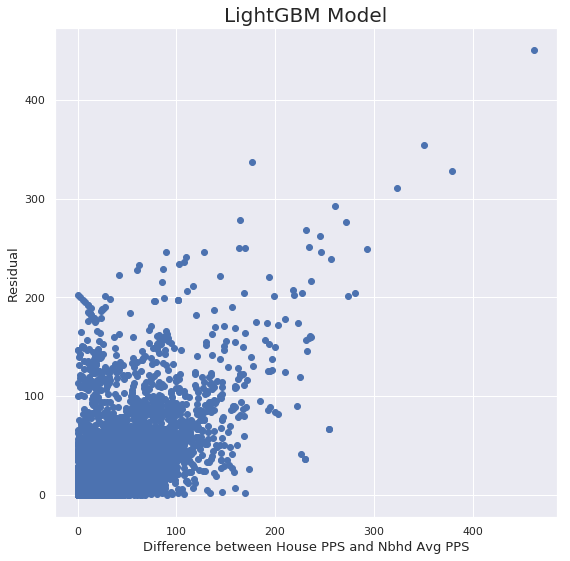

In [23]:
diff = np.abs(copiedlgb['Actual']-copiedlgb['Log-NbhdPPS'].map(lambda x: np.exp(x)))
plt.figure(figsize=(9,9))
plt.scatter(diff,copiedlgb['Residual'])
plt.xlabel('Difference between House PPS and Nbhd Avg PPS', fontsize=13)
plt.ylabel('Residual', fontsize=13)
plt.title('LightGBM Model', fontsize=20)
#So the residual is linearly correlated with how different the house's PPS is from the average PPS in its neighborhood.
#However, NeighborhoodPPS is an important feature in the ML model and performance suffers without it
#To me, this means the NeighborhoodPPS is a good start for a metric, but can be improved (with historical sales data)
#In my next iteration of the model, I'll put in more info about sales in each neighborhood.

## Model Interpretation with SHAP
Features in red pushed the prediction higher, features in blue pushed it lower. 
SHAP visualizes with D3 and GitHub doesn't display JavaScript so I won't add any SHAP plots past these 2 for now.

## Visualize the feature effects for the 200th prediction (chosen as a random example)
## Features in red pushed the prediction higher, blue features pushed it lower.

![title](shap.png)